<a href="https://colab.research.google.com/github/dbenayoun/IASD/blob/main/ProjetIA/Copie_de_Adversarial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from random import random
import pandas as pd
import matplotlib.pyplot as plt


cuda = torch.cuda.is_available()

## From adversarial examples to training robust models

In the previous notebooks, we focused on methods for solving the maximization problem over perturbations; that is, to finding the solution to the problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

In this notebook, we will focus on training a robust classifier. More precisly, we aim at solving following minimization problem, namely Adversarial Training:
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
The order of the min-max operations is important here.  Specially, the max is inside the minimization, meaning that the adversary (trying to maximize the loss) gets to "move" _second_.  We assume, essentially, that the adversary has full knowledge of the classifier parameters $\theta$, and that they get to specialize their attack to whatever parameters we have chosen in the outer minimization. The goal of the robust optimization formulation, therefore, is to ensure that the model cannot be attacked _even if_ the adversary has full knowledge of the model.  Of course, in practice we may want to make assumptions about the power of the adversary but it can be difficult to pin down a precise definition of what we mean by the "power" of the adversary, so extra care should be taken in evaluating models against possible "realistic" adversaries.

# Fucntions
1. Train a robust classifier using Adversarial Training with a specific norm
2. Evaluate your classifier on natural and adversarial examples crafted with the norm of the training and other norms
3. Make an analysis and conclude

In [2]:
# load CIFAR10 dataset
def load_cifar(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.CIFAR10("./docs", train=split, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

batch_size = 100
train_loader = load_cifar('train', batch_size)
test_loader = load_cifar('test', batch_size)



100%|██████████| 170M/170M [00:04<00:00, 34.3MB/s]


Extracting ./docs/cifar-10-python.tar.gz to ./docs
Files already downloaded and verified


In [3]:
class ConvModel(torch.nn.Module):

  def __init__(self):
    super(ConvModel, self).__init__()
    # First Convolutional Layer: Input channels = 3, Output channels = 32
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    # First Max Pooling Layer: Reduces each dimension by a factor of 2
    self.pool1 = nn.MaxPool2d(kernel_size=2)

    # Second Convolutional Layer: Input channels = 32, Output channels = 64
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    # Second Max Pooling Layer: Reduces each dimension by a factor of 2
    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)  # Assuming 10 output classes


  def forward(self, x):
    # First convolutional block: Conv -> ReLU -> MaxPool
    x = self.pool1(nn.functional.relu(self.conv1(x)))
    # Second convolutional block: Conv -> ReLU -> MaxPool
    x = self.pool2(nn.functional.relu(self.conv2(x)))

    # Flatten the output for the fully connected layers
    x = x.view(-1, 64 * 8 * 8)  # Flattening the output from conv layers

    # First fully connected block: FC -> ReLU
    x = nn.functional.relu(self.fc1(x))
    # Second fully connected block: FC -> ReLU
    x = nn.functional.relu(self.fc2(x))
    # Output layer: FC
    x = self.fc3(x)

    return x

In [18]:
class FastGradientSignMethod:

  def __init__(self, model, eps):
    self.model = model
    self.eps = eps


  def compute(self, x, y):
    """ Construct FGSM adversarial perturbation for examples x"""
    delta = torch.zeros_like(x, requires_grad=True)
    # code here ...
    criterion = nn.CrossEntropyLoss()
    output = self.model(x + delta)
    loss = criterion(output, y)
    loss.backward()
    # Use variable.grad.detach() to retreive the gradient with respect to a loss
    grad = delta.grad.detach()
    delta = self.eps * grad.sign()

    return delta


class ProjectedGradientDescent:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha
    self.num_iter = num_iter

  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    # delta = torch.randn_like(x, requires_grad=True)
    delta = torch.zeros_like(x, requires_grad=True)
    for t in range(self.num_iter):
      adv = torch.clamp(x + delta, 0, 1)
      loss = nn.CrossEntropyLoss()(self.model(adv), y)
      loss.backward()
      delta.data = (delta.data + self.alpha * delta.grad.sign()).clamp(-self.eps, self.eps)
      delta.grad.zero_()
    return delta.detach()


class ProjectedGradientDescentL2:

    def __init__(self, model, eps, alpha, num_iter):
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.num_iter = num_iter

    def compute(self, x, y):

        # initialize the perturbation delta to zero, and require gradient for optimization
        delta = torch.zeros_like(x, requires_grad=True)

        # iteratively compute adversarial perturbations
        for t in range(self.num_iter):
            # add perturbation to the input and clamp values between [0, 1]
            adv = x + delta
            adv = torch.clamp(adv, 0, 1)  # Ensure the values are in [0,1]
            output = self.model(adv)
            loss = nn.CrossEntropyLoss()(output, y)
            mask = 1 * (torch.max(output, 1)[1] == y)
            loss.backward()
            grad_norm = torch.norm(delta.grad.detach(), p=2, dim=[1, 2, 3])
            normalized_grad = delta.grad.detach() / (grad_norm.view(-1, 1, 1, 1) + 1e-10)
            delta.data += self.alpha * normalized_grad * mask.view(-1, 1, 1, 1)
            shape_perturb = delta.data.shape
            delta.data = torch.renorm(delta.detach().reshape(delta.size(0), -1), p=2, dim=1, maxnorm=self.eps)
            delta.data = delta.data.reshape(*shape_perturb)
            delta.data = torch.clamp(x.data + delta.data, 0, 1) - x.data
            delta.grad.zero_()

        # Return the computed adversarial perturbation
        return delta.detach()

class ProjectedGradientDescentLinfinity:

    def __init__(self, model, eps, alpha, num_iter):
        self.model = model
        self.eps = eps  # Maximum allowed perturbation
        self.alpha = alpha  # Step size for each iteration
        self.num_iter = num_iter  # Number of iterations

    def compute(self, x, y):
        delta = torch.zeros_like(x, requires_grad=True)  # Initialize perturbation

        for t in range(self.num_iter):
            adv = x + delta  # Add perturbation to input
            adv = torch.clamp(adv, 0, 1)  # Ensure the values are in [0, 1]

            loss = nn.CrossEntropyLoss()(self.model(adv), y)  # Calculate loss
            loss.backward()  # Compute gradients

            # Normalize the gradients using L_inf
            delta.data += self.alpha * torch.sign(delta.grad.detach())  # Take sign of gradient for L_inf
            delta.data = torch.clamp(delta.data, -self.eps, self.eps)  # Project delta to be within [-eps, eps]

            delta.grad.zero_()  # Reset the gradients for the next iteration

        return delta.detach()  # Return the final perturbation


In [15]:
class ProjectedGradientDescentL2:
    """
    Implements the Projected Gradient Descent (PGD) attack in L2 norm for adversarial example generation.

    Attributes:
        model (torch.nn.Module): The model to attack.
        eps (float): Maximum perturbation (L2 norm bound).
        alpha (float): Step size for each iteration.
        num_iter (int): Number of iterations for the attack.
    """
    def __init__(self, model, eps, alpha, num_iter):
        """
        Initializes the PGD attack.

        Args:
            model (torch.nn.Module): The model to attack.
            eps (float): Maximum L2 norm of the perturbation.
            alpha (float): Step size for the attack.
            num_iter (int): Number of attack iterations.
        """
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.num_iter = num_iter

    def compute(self, x, y):
        """
        Generates an adversarial perturbation using PGD with L2 norm.

        Args:
            x (torch.Tensor): Original input images.
            y (torch.Tensor): True labels for the input images.

        Returns:
            torch.Tensor: The computed adversarial perturbations.
        """
        # initialize the perturbation delta to zero, and require gradient for optimization
        delta = torch.zeros_like(x, requires_grad=True)

        # iteratively compute adversarial perturbations
        for t in range(self.num_iter):
            # add perturbation to the input and clamp values between [0, 1]
            adv = x + delta
            adv = torch.clamp(adv, 0, 1)  # Ensure the values are in [0,1]

            # get model output and compute loss (cross-entropy)
            output = self.model(adv)
            loss = nn.CrossEntropyLoss()(output, y)

            # create a mask to ignore correctly classified samples
            mask = 1 * (torch.max(output, 1)[1] == y)

            # backpropagate the loss to get gradients w.r.t delta
            loss.backward()

            # compute the L2 norm of the gradient
            grad_norm = torch.norm(delta.grad.detach(), p=2, dim=[1, 2, 3])

            # normalize the gradient for L2 projection
            normalized_grad = delta.grad.detach() / (grad_norm.view(-1, 1, 1, 1) + 1e-10)

            # update delta using gradient ascent while applying the mask for correct classifications
            delta.data += self.alpha * normalized_grad * mask.view(-1, 1, 1, 1)

            # reshape delta for renormalization
            shape_perturb = delta.data.shape

            # apply L2 projection to ensure perturbation is within the epsilon ball
            delta.data = torch.renorm(delta.detach().reshape(delta.size(0), -1), p=2, dim=1, maxnorm=self.eps)
            delta.data = delta.data.reshape(*shape_perturb)

            # ensure the final perturbation keeps the adversarial example within valid pixel range [0, 1]
            delta.data = torch.clamp(x.data + delta.data, 0, 1) - x.data

            # zero out the gradients for the next iteration
            delta.grad.zero_()

        # Return the computed adversarial perturbation
        return delta.detach()

In [5]:
def adversarial_train_model(model, criterion, optimizer, loader, epochs=5, attack=None, perc_attacked=1, verbose=True):
  """Function to train the model"""

  f = 0
  train_losses = []
  for e in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        if cuda:
          images, labels = images.cuda(), labels.cuda()
        f = f + 1
        model.train() # - Set the model to train mode
        optimizer.zero_grad()# - Reset the optimizer

        if attack is None:
          output = model(images)
        else:
          if random() < perc_attacked:
            delta = attack.compute(images, labels)
            output = model(images + delta)
          else:
            output = model(images)

        loss = criterion(output, labels)# - Compute the loss
        loss.backward()# - Backward pass
        optimizer.step()# - Update the weights
    if verbose:
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(e+1, loss.item()))
    train_losses.append(loss.item()) #save loss

  return train_losses


In [64]:
def eval_model(model, loader, attack=None, attack_name='', verbose=True):
  """Function to evaluate your model on a specific loader"""
  accuracy = 0.
  n_inputs = 0.
  for n_batch, (imgs, labels) in enumerate(loader):
    if cuda:
      imgs, labels = imgs.cuda(), labels.cuda()
    if attack is None:
      outputs = model(imgs)
    else:
      delta = attack.compute(imgs, labels)
      adv = imgs + delta
      outputs = model(adv)
    _, predicted = torch.max(outputs.data, 1)
    accuracy += predicted.eq(labels.data).cpu().sum().numpy()
    n_inputs += imgs.shape[0]
  accuracy /= n_inputs

  if verbose:
    if attack is None:
      print('Clean Accuracy, accuracy on testset: {:.4f}'.format(accuracy))
    else:
      print('Robust Accuracy, accuracy on testset with attack {}: {:.4f}'.format(attack_name, accuracy))

  return accuracy

# Test attack

In [7]:
def plot_images(x, y, yp, M=5, N=5):
  x = x.cpu().numpy()
  y = y.cpu().numpy()
  f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N*2, M*1.3))
  for i in range(M):
    for j in range(N):
      img = x[i*N+j].transpose(1, 2, 0)
      img = np.maximum(0, np.minimum(img, 1))
      ax[i][j].imshow(img)
      title = ax[i][j].set_title("Pred: {}".format(cifar10_classes[int(yp[i*N+j].max(dim=0)[1])]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()

for imgs, labels in test_loader:
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
  break

# Adversarial Attacks on CIFAR-10: Robustness and Tradeoffs


## 1. Initial Analysis: Training Robust Models and Accuracy Tradeoff


### A. Training Strategies for Robustness

#### **Standard Training**

In [8]:
print('Model without attack:')
# adverserial training with PGD
model_noattack = ConvModel()
if cuda:
  model_noattack = model_noattack.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_noattack.parameters(), lr=0.001)
#define attack
attack = None
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_noattack, criterion, opt, train_loader, epochs, attack, perc_attacked, verbose=True)

Model without attack:
Epoch: 1 	Training Loss: 1.502471
Epoch: 2 	Training Loss: 1.255090
Epoch: 3 	Training Loss: 0.924301
Epoch: 4 	Training Loss: 1.237332
Epoch: 5 	Training Loss: 0.658681
Epoch: 6 	Training Loss: 0.818949
Epoch: 7 	Training Loss: 0.721535
Epoch: 8 	Training Loss: 0.795031
Epoch: 9 	Training Loss: 0.826587
Epoch: 10 	Training Loss: 0.550331
Epoch: 11 	Training Loss: 0.559623
Epoch: 12 	Training Loss: 0.434545
Epoch: 13 	Training Loss: 0.578967
Epoch: 14 	Training Loss: 0.365621
Epoch: 15 	Training Loss: 0.325739
Epoch: 16 	Training Loss: 0.487879
Epoch: 17 	Training Loss: 0.341336
Epoch: 18 	Training Loss: 0.136796
Epoch: 19 	Training Loss: 0.118718
Epoch: 20 	Training Loss: 0.232647


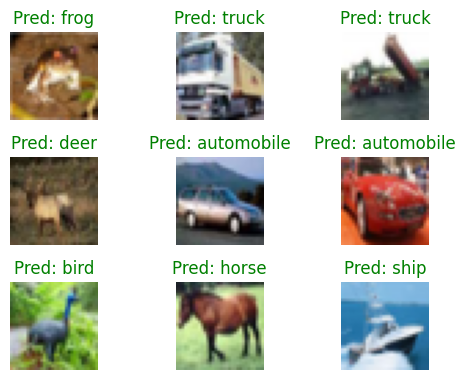

In [44]:
# plot natural images
output = model_noattack(imgs)
plot_images(imgs, labels, output, 3, 3)

In [30]:
#Defining my attacks
fgsm = FastGradientSignMethod(model_noattack, 0.1)
pdg_l0 = ProjectedGradientDescent(model_noattack, eps=0.03, alpha=0.006, num_iter=10)
pdg_l2 = ProjectedGradientDescentL2(model_noattack, eps=0.14, alpha=0.14, num_iter=10)
pdg_linf = ProjectedGradientDescentLinfinity(model_noattack, 0.1, 0.001, 10)


In [21]:
#Clean Accuracy: eval model on not attacked test set
eval_model(model_noattack, test_loader)

#Robust Accuracy: eval model attacked test set
eval_model(model_noattack, test_loader, fgsm, 'FGSM')
eval_model(model_noattack, test_loader, pdg_l0, 'PGD L0')
eval_model(model_noattack, test_loader, pdg_l2, 'PGD L2')
eval_model(model_noattack, test_loader, pdg_linf, 'PGD Linf')

Clean Accuracy, accuracy on testset: 0.9530
Robust Accuracy, accuracy on testset with attack FGSM: 0.0036
Robust Accuracy, accuracy on testset with attack PGD L0: 0.0004
Robust Accuracy, accuracy on testset with attack PGD L2: 0.0060
Robust Accuracy, accuracy on testset with attack PGD Linf: 0.1122


We see that our model is very sensitive to the different attacks, making drop the accuracy.

Target of the project is to improve the robust accuracy with adversarial training.

#### **Adversarial Training**

1. FGSM

In [22]:
print('Model with attack FGSM:')
# adverserial training with PGD
model_withattackFGSM = ConvModel()
if cuda:
  model_withattack = model_withattackFGSM.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackFGSM.parameters(), lr=0.01)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackFGSM, criterion, opt, train_loader, epochs,
                                       attack=fgsm, perc_attacked=perc_attacked, verbose=True)

Model with attack FGSM:
Epoch: 1 	Training Loss: 1.767667
Epoch: 2 	Training Loss: 1.073646
Epoch: 3 	Training Loss: 1.058886
Epoch: 4 	Training Loss: 0.859444
Epoch: 5 	Training Loss: 0.810446
Epoch: 6 	Training Loss: 0.711908
Epoch: 7 	Training Loss: 0.658152
Epoch: 8 	Training Loss: 0.959441
Epoch: 9 	Training Loss: 0.745139
Epoch: 10 	Training Loss: 0.761066
Epoch: 11 	Training Loss: 0.641815
Epoch: 12 	Training Loss: 0.581802
Epoch: 13 	Training Loss: 0.987303
Epoch: 14 	Training Loss: 0.807209
Epoch: 15 	Training Loss: 0.514740
Epoch: 16 	Training Loss: 0.884555
Epoch: 17 	Training Loss: 0.626973
Epoch: 18 	Training Loss: 0.650052
Epoch: 19 	Training Loss: 0.593481
Epoch: 20 	Training Loss: 0.942630


Classification with attacked img of a standard training


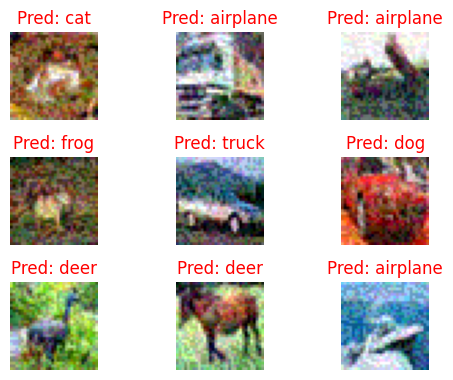

Classification with attacked img of an adversarial training


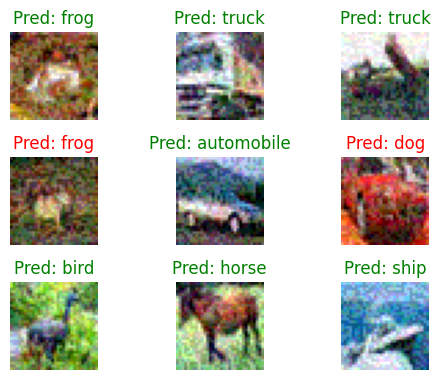

In [23]:
# plot natural images
delta = fgsm.compute(imgs, labels)
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackFGSM(imgs+delta), M=3, N=3)

In [24]:
eval_model(model_withattackFGSM, test_loader, fgsm, 'FGSM')

Robust Accuracy, accuracy on testset with attack FGSM: 0.7710


2. PGB L0

When using PGD for adversarial training, it's normal for the model to struggle with convergence compared to FGSM or standard training. This is because PGD generates stronger, more challenging adversarial examples through iterative optimization, making the training harder. PGD requires more careful tuning of hyperparameters like learning rate and attack step size. To help, consider adjusting the learning rate, experimenting with different PGD parameters, or using a mix of FGSM and PGD in the early stages of training.

In [26]:
print('Model with attack PGD L0:')
# adverserial training with PGD
model_withattackPGD = ConvModel()
if cuda:
  model_withattackPGD = model_withattackPGD.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGD.parameters(), lr=0.001)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackPGD, criterion, opt, train_loader, epochs, attack=pdg_l0, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD L0:
Epoch: 1 	Training Loss: 1.428135
Epoch: 2 	Training Loss: 1.381387
Epoch: 3 	Training Loss: 1.175395
Epoch: 4 	Training Loss: 0.963270
Epoch: 5 	Training Loss: 0.758358
Epoch: 6 	Training Loss: 0.833825
Epoch: 7 	Training Loss: 0.517633
Epoch: 8 	Training Loss: 0.544300
Epoch: 9 	Training Loss: 0.462903
Epoch: 10 	Training Loss: 0.235618
Epoch: 11 	Training Loss: 0.328679
Epoch: 12 	Training Loss: 0.194254
Epoch: 13 	Training Loss: 0.245227
Epoch: 14 	Training Loss: 0.244739
Epoch: 15 	Training Loss: 0.180115
Epoch: 16 	Training Loss: 0.148938
Epoch: 17 	Training Loss: 0.190343
Epoch: 18 	Training Loss: 0.135204
Epoch: 19 	Training Loss: 0.075074
Epoch: 20 	Training Loss: 0.099441


Classification with attacked img of a standard training


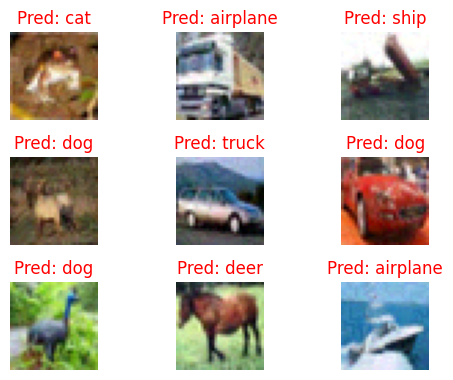

Classification with attacked img of an adversarial training


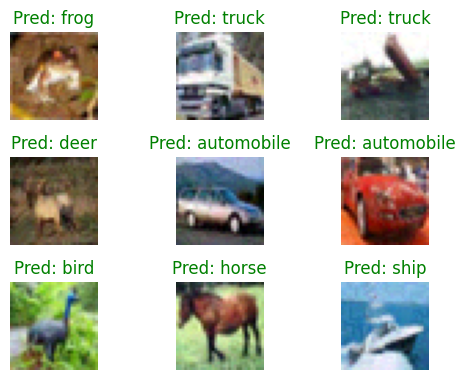

In [27]:
# plot natural images
delta = pdg_l0.compute(imgs, labels)
#print("Classification non attacked img of a standard training")
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackPGD(imgs+delta), M=3, N=3)

In [28]:
eval_model(model_withattackPGD, test_loader, pdg_l0, 'PGD L0')


Robust Accuracy, accuracy on testset with attack PGD L0: 0.9759


3. PGD L2

In [31]:
print('Model with attack PGD L2:')
# adverserial training with PGD
model_withattackPGDL2 = ConvModel()
if cuda:
  model_withattack = model_withattackPGDL2.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGDL2.parameters(), lr=0.001)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackPGDL2, criterion, opt, train_loader, epochs, attack=pdg_l2, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD L2:
Epoch: 1 	Training Loss: 1.193597
Epoch: 2 	Training Loss: 1.307207
Epoch: 3 	Training Loss: 1.283087
Epoch: 4 	Training Loss: 1.263735
Epoch: 5 	Training Loss: 0.837456
Epoch: 6 	Training Loss: 0.962919
Epoch: 7 	Training Loss: 0.907220
Epoch: 8 	Training Loss: 0.970881
Epoch: 9 	Training Loss: 0.747407
Epoch: 10 	Training Loss: 0.668787
Epoch: 11 	Training Loss: 0.748917
Epoch: 12 	Training Loss: 0.521256
Epoch: 13 	Training Loss: 0.582526
Epoch: 14 	Training Loss: 0.455362
Epoch: 15 	Training Loss: 0.432906
Epoch: 16 	Training Loss: 0.377080
Epoch: 17 	Training Loss: 0.328080
Epoch: 18 	Training Loss: 0.391949
Epoch: 19 	Training Loss: 0.195708
Epoch: 20 	Training Loss: 0.272632


Classification with attacked img of a standard training


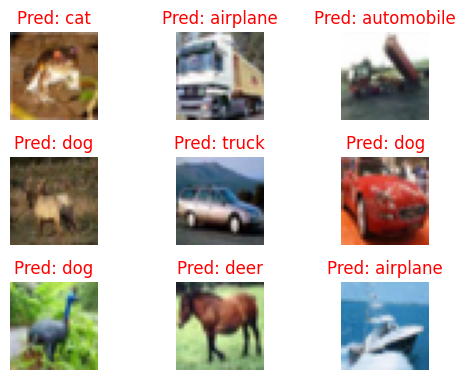

Classification with attacked img of an adversarial training


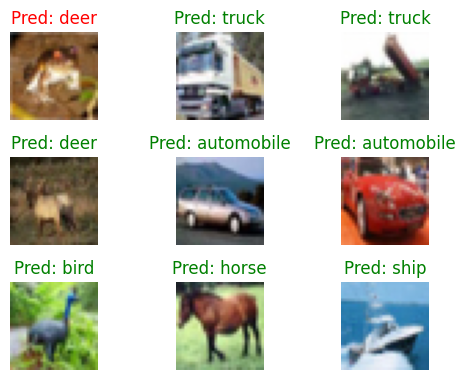

In [32]:
# plot natural images
delta = pdg_l2.compute(imgs, labels)
#print("Classification non attacked img of a standard training")
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackPGD(imgs+delta), M=3, N=3)

In [34]:
eval_model(model_withattackPGDL2, test_loader, pdg_l2, 'PGD L2')


Robust Accuracy, accuracy on testset with attack PGD L2: 0.9563


4. PGD Linf


In [35]:
print('Model with attack PGD Linf:')
# adverserial training with PGD
model_withattackPGDLinf = ConvModel()
if cuda:
  model_withattack = model_withattackPGDLinf.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGDLinf.parameters(), lr=0.001)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackPGDLinf, criterion, opt, train_loader, epochs, attack=pdg_linf, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD Linf:
Epoch: 1 	Training Loss: 1.413841
Epoch: 2 	Training Loss: 1.276112
Epoch: 3 	Training Loss: 1.175437
Epoch: 4 	Training Loss: 0.942916
Epoch: 5 	Training Loss: 0.816645
Epoch: 6 	Training Loss: 0.965074
Epoch: 7 	Training Loss: 0.803222
Epoch: 8 	Training Loss: 0.825397
Epoch: 9 	Training Loss: 0.915357
Epoch: 10 	Training Loss: 0.512225
Epoch: 11 	Training Loss: 0.662084
Epoch: 12 	Training Loss: 0.511301
Epoch: 13 	Training Loss: 0.684105
Epoch: 14 	Training Loss: 0.407274
Epoch: 15 	Training Loss: 0.475368
Epoch: 16 	Training Loss: 0.338122
Epoch: 17 	Training Loss: 0.287388
Epoch: 18 	Training Loss: 0.246574
Epoch: 19 	Training Loss: 0.306226
Epoch: 20 	Training Loss: 0.377894


Classification with attacked img of a standard training


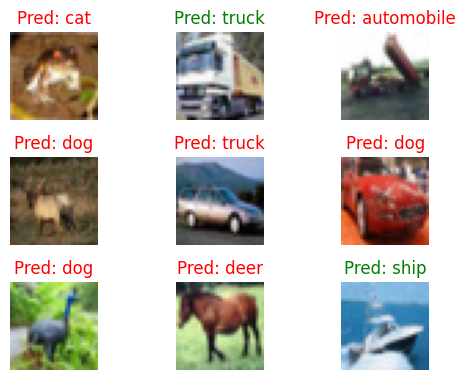

Classification with attacked img of an adversarial training


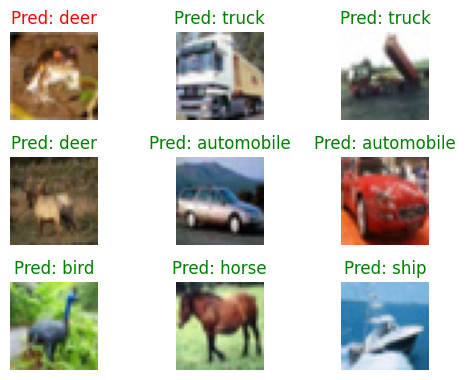

In [36]:
# plot natural images
delta = pdg_linf.compute(imgs, labels)
#print("Classification non attacked img of a standard training")
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackPGD(imgs+delta), M=3, N=3)

In [37]:
eval_model(model_withattackPGDLinf, test_loader, pdg_linf, 'PGD Linf')


Robust Accuracy, accuracy on testset with attack PGD Linf: 0.9361


Save and load models

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
#save models in MyDrive\Dauphine
torch.save(model_noattack.state_dict(), '/content/drive/MyDrive/Dauphine /Adversarial/model_noattack.pth')
torch.save(model_withattackFGSM.state_dict(), '/content/drive/MyDrive/Dauphine /Adversarial/model_withattackFGSM.pth')
torch.save(model_withattackPGD.state_dict(), '/content/drive/MyDrive/Dauphine /Adversarial/model_withattackPGD.pth')
torch.save(model_withattackPGDL2.state_dict(), '/content/drive/MyDrive/Dauphine /Adversarial/model_withattackPGDL2.pth')
torch.save(model_withattackPGDLinf.state_dict(), '/content/drive/MyDrive/Dauphine /Adversarial/model_withattackPGDLinf.pth')



In [43]:
#load model
model_noattack.load_state_dict(torch.load('/content/drive/MyDrive/Dauphine /Adversarial/model_noattack.pth'))
model_withattackFGSM.load_state_dict(torch.load('/content/drive/MyDrive/Dauphine /Adversarial/model_withattackFGSM.pth'))
model_withattackPGD.load_state_dict(torch.load('/content/drive/MyDrive/Dauphine /Adversarial/model_withattackPGD.pth'))
model_withattackPGDL2.load_state_dict(torch.load('/content/drive/MyDrive/Dauphine /Adversarial/model_withattackPGDL2.pth'))
model_withattackPGDLinf.load_state_dict(torch.load('/content/drive/MyDrive/Dauphine /Adversarial/model_withattackPGDLinf.pth'))



<ipython-input-43-1eb4c993b696>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_noattack.load_state_dict(torch.load('/content/drive/MyDrive/Dauphine /Adversarial/mode

<All keys matched successfully>

### B. Evaluating Robustness vs. Accuracy Tradeoff

In [69]:
res = {"Model": [], "Attack": [], "Accuracy": []}

models = [model_noattack, model_withattackFGSM, model_withattackPGD, model_withattackPGDL2, model_withattackPGDLinf]
models_name = ["model_noattack", "model_withattackFGSM", "model_withattackPGD", "model_withattackPGDL2", "model_withattackPGDLinf"]
attacks = [None, fgsm, pdg_l0, pdg_l2, pdg_linf]
attack_names = ["None", "FGSM", "PGD L0", "PGD L2", "PGD Linf"]

for model, model_name in zip(models, models_name):
  for attack, attack_name in zip(attacks, attack_names):
    res["Model"].append(model_name)
    res["Attack"].append(attack_name)
    res["Accuracy"].append(eval_model(model, test_loader, attack, attack_name, verbose=False))

    print(f'model: {model_name}, attack: {attack_name}')


model: model_noattack, attack: None
model: model_noattack, attack: FGSM
model: model_noattack, attack: PGD L0
model: model_noattack, attack: PGD L2
model: model_noattack, attack: PGD Linf
model: model_withattackFGSM, attack: None
model: model_withattackFGSM, attack: FGSM
model: model_withattackFGSM, attack: PGD L0
model: model_withattackFGSM, attack: PGD L2
model: model_withattackFGSM, attack: PGD Linf
model: model_withattackPGD, attack: None
model: model_withattackPGD, attack: FGSM
model: model_withattackPGD, attack: PGD L0
model: model_withattackPGD, attack: PGD L2
model: model_withattackPGD, attack: PGD Linf
model: model_withattackPGDL2, attack: None
model: model_withattackPGDL2, attack: FGSM
model: model_withattackPGDL2, attack: PGD L0
model: model_withattackPGDL2, attack: PGD L2
model: model_withattackPGDL2, attack: PGD Linf
model: model_withattackPGDLinf, attack: None
model: model_withattackPGDLinf, attack: FGSM
model: model_withattackPGDLinf, attack: PGD L0
model: model_withatta

In [70]:
pd.DataFrame(res).to_csv('/content/drive/MyDrive/Dauphine /Adversarial/res.csv')


In [72]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(res)

# Pivot the DataFrame
pivot_df = df.pivot(index="Model", columns="Attack", values="Accuracy").fillna("-")

# Display the pivoted DataFrame
print(pivot_df[attack_names])

Attack                      None     FGSM   PGD L0   PGD L2  PGD Linf
Model                                                                
model_noattack           0.95304  0.00356  0.00044  0.00596   0.11220
model_withattackFGSM     0.19284  0.77102  0.44116  0.23664   0.27410
model_withattackPGD      0.56362  0.89612  0.97590  0.67874   0.78946
model_withattackPGDL2    0.96568  0.32022  0.79416  0.95632   0.93894
model_withattackPGDLinf  0.92646  0.62760  0.92014  0.92838   0.93610
